In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from numpy.random import Generator, PCG64

# Ornstein-Uhlenbeck Noise

In this lecture, we will try to modify a bit the already studied **Harvest Process** applying a different kind of noise. The noise considered today will be the Ornstein-Uhlenbeck Noise which is the noise produced by the homonomous process. This process with zero mean can be expressed in the Ito's way as

$$
dY=-\frac{1}{\theta}Ydt+\sigma dW
$$

where $\theta$ is the autocorrelation (or memory) time and $\sigma$ controls the amplitude of the white gaussian noise contribution. As we can immediately notice, this noise is not made only by the stochastic contribution but has a deterministic part. This term is able to produce a memory effect on the noise therefore this noise is not a *martingale* differently from the Wiener Process.

We can start to understand how to simulate this process as first thing.

## Qualitative Analysis

As always, we can first take a look to the properties of this noise and more in particular to its steady state PDF:

In [2]:
# LOOK TO BLACKBOARD, PLEASE

Thus, we can obtain that the SS-PDF is a Gaussian distribution $N(0,\theta\sigma^2/2)$:

$$
P_s(x)=\sqrt{\frac{1}{\pi\theta\sigma^2}}\exp\left(-\frac{x^2}{\theta\sigma^2}\right)
$$

Therefore, its mometums are:

$$
E[x]=0;\qquad\qquad Var[x]=\frac{\theta\sigma^2}{2};
$$

## OU Class

After the qualitative analysis, we can create the class for the Ornstein-Ulhenbeck process to check our results

In [3]:
# THE CLASS

class OU(object):
    '''
    This class is used to simulate trajectories for an Ornstein-Uhlenbeck process.
    '''

    def __init__(self,theta: float,sigma: float)->None:
        self.theta = theta
        self.sigma = sigma

        if(theta<=0 or sigma<0):
            raise RuntimeError("One of the given parameters is zero or negative.")

        return

    def __checkInputs(self,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''
        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        return

    def __RK4(self,t_n: float,y_n: float,h: float)->float:
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4 for the 
        deterministic part of the OU process
        '''
        self.__checkInputs(t_n,10)
        
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        f = lambda x: -(1.0/self.theta)*x
        
        k_1 = f(y_n)
        k_2 = f(y_n+h*k_1/2)
        k_3 = f(y_n+h*k_2/2)
        k_4 = f(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
        
    def simulateTraj(self,x0: float,T: float,N: int):
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory for the OU process.
        '''
        self.__checkInputs(T,N)

        if T==0:
            return np.array([x0])

        h = T/N
        traj = np.zeros(N+1,dtype=float)
        traj[0] = x0
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        rng = Generator(PCG64())

        for i in range(1,N+1):
            time[i] = i*h
            dx = self.__RK4(time[i-1],traj[i-1],h) 
            dx += self.sigma*rng.normal()*np.sqrt(h) 
            traj[i] = traj[i-1] + dx

        return traj,time

Now we can try to simulate a trajectory: we will consider $\theta=0.1$ and $\sigma=0.05$

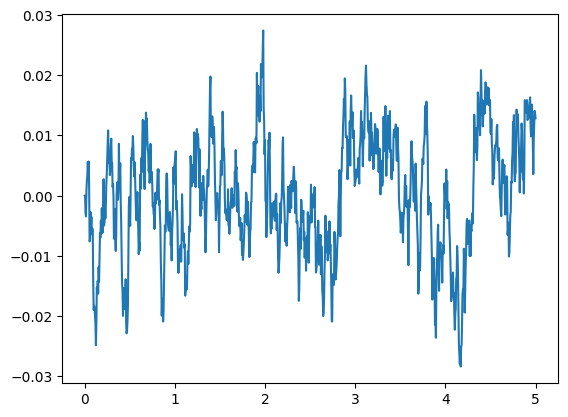

In [4]:
system = OU(0.1,0.05)

ptraj,ttraj = system.simulateTraj(0,5,1000)

plt.plot(ttraj,ptraj)

The trajectory seems quite sensible. We can immediately notice the important influence of the finite-ness of the variance which is able to contain much more the trajectory, differently from the Wiener process.

## Simulations

Ok, let's try to compute the SSPDF for the OU process. Using this as noise, we usually would like to start a near as possible to the region of interest thus we will set $x_0\equiv0$ instead of randomly picking it in a interval. 

Another issue comes also from having a not-limited domain therefore we will need to use another approach for the binning. The idea is fairly simple: we can pick the maximum and the minimum value on the domain and then produce bins between these two values.

In [5]:
Nsim = 1000
nbins = 50
theta = 0.1
sigma = 0.05
system = OU(theta,sigma)

data = np.zeros(Nsim,dtype=float)

for i in range(Nsim):
    ptraj,ttraj = system.simulateTraj(0,5,1000)
    data[i] = ptraj[-1]

m = np.min(data)
M = np.max(data)
delta = (M-m)/nbins

bins = np.zeros(nbins,dtype=float)

for i in range(Nsim):
    for j in range(nbins):
        if(data[i] <= (m+(j+1)*delta)):
            bins[j] += 1.0
            break

bins = bins/(Nsim*delta)

print(bins)

[ 0.64221692  0.          0.          0.64221692  0.64221692  1.92665077
  0.64221692  1.92665077  1.28443385  1.28443385  1.92665077  5.13773539
  7.70660308  5.13773539 10.27547077 11.55990462 19.90872462 23.11980924
 12.20212154 19.90872462 28.89976155 23.11980924 25.68867693 37.89079848
 37.24858155 42.38631694 23.76202616 32.75306309 26.97311078 34.03749694
 30.1841954  28.89976155 23.76202616 23.11980924 18.62429078 14.77098924
  7.70660308  9.63325385 16.05542308  5.77995231  5.77995231  5.77995231
  5.13773539  5.77995231  0.64221692  0.          1.28443385  0.
  0.          0.64221692]


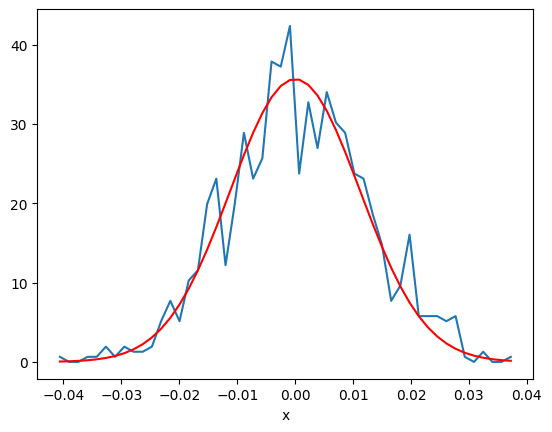

In [6]:
x = np.linspace(m,M,nbins)

f = lambda x: np.sqrt(1.0/(np.pi*theta*sigma*sigma))*np.exp(-x**2/(theta*sigma*sigma))

plt.xlabel("x")
plt.plot(x,bins)
plt.plot(x,f(x),color='r')

It seems quite decent. The simulations are a bit cospicuos so there are still some irregularities but the simulations fit decently with the theoretical PDF.

Now, we can notice something strange. If we diminish the length of the simulations:

In [7]:
Nsim = 1000
nbins = 50
theta = 0.1
sigma = 0.05
system = OU(theta,sigma)

data = np.zeros(Nsim,dtype=float)

for i in range(Nsim):
    ptraj,ttraj = system.simulateTraj(0,0.05,1000) #WE ARE CHANGING THE LENGHT KEEPING THE SAME STEPS
    data[i] = ptraj[-1]

m = np.min(data)
M = np.max(data)
delta = (M-m)/nbins

bins = np.zeros(nbins,dtype=float)

for i in range(Nsim):
    for j in range(nbins):
        if(data[i] <= (m+(j+1)*delta)):
            bins[j] += 1.0
            break

bins = bins/(Nsim*delta)

print(bins)

[ 0.937534    0.          0.937534    0.937534    4.68766999  2.812602
  3.750136    8.43780599  2.812602   10.31287399  8.43780599 15.00054398
 11.25040799 25.31341797 15.00054398 22.50081597 26.25095197 30.93862196
 31.87615596 38.43889395 45.93916595 42.18902995 42.18902995 42.18902995
 42.18902995 43.12656395 47.81423394 52.50190394 37.50135996 38.43889395
 35.62629196 31.87615596 23.43834997 31.87615596 20.62574798 17.81314598
 15.93807798 15.93807798  8.43780599 13.12547598  4.68766999  1.875068
  5.62520399  4.68766999  2.812602    3.750136    1.875068    0.937534
  0.          1.875068  ]


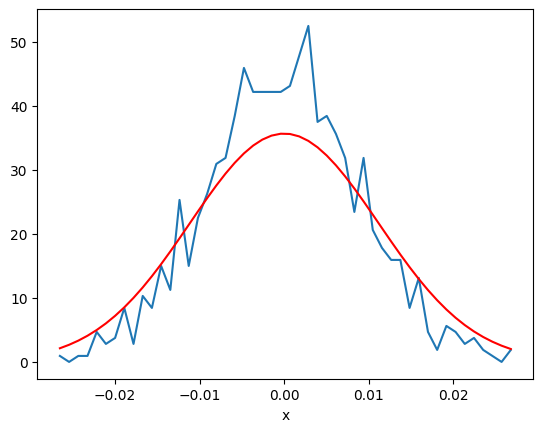

In [8]:
x = np.linspace(m,M,nbins)

f = lambda x: np.sqrt(1.0/(np.pi*theta*sigma*sigma))*np.exp(-x**2/(theta*sigma*sigma))

plt.xlabel("x")
plt.plot(x,bins)
plt.plot(x,f(x),color='r')

As we can notice with $T=0.05$ we are not able to obtain a good distribution and the resulting SSPDF seems to be more peaked around the expected value 0.
The explanation is fairly simple: the distribution we are producing is not the steady state one but is a transient one. This reason is perfectly correct and it is the only one however this can be a bit problematic in certain situations.

We are simulating the OU process so, in this frame, we are focusing on studying this process. However, when using the OU as a noise for a system this could be characterized by memory times far lower then the one necessary to obtain the SSPDF of the studied system usually. On the other hand, especially for complex systems, producing too long trajectories can be cumbersome in terms of computational resources. Thus some remedies are needed. 

There are two main approaches:

- **Working on the initial condition**: the first way is to produce the initial values of the noise already distributed according to the steady state distribution of the noise process. For the OU this is very doable and quite easy however this is not always the best solution: for some noise process the PDF could have a very strange shape and to produce values randomly distributed in such way could be difficult.
- **Warm Up**: this second way requires more computational resources but it is universally valid and it is used widely in the numerical field. The idea is to simulate first for a certain time only the noise and then use the last point of the noise simulations as initial conditions for the noise in the main system.

For our simulations in this case we will opt for the first one.

### Side Topic: Autocorrelation and memory

In a lot of systems and situations could be very interesting to study the memory effect in the trajectories. Usually this happen in systems with noises characterised by memory but also when working with possible semi-periodic behaviour induced by noisy fluctuations. Anyway, I would like to show briefly how you can analyse the autocorrelation/memory of your system.

Given our OU system, we can compute the autocorrelation in this way: given a certain time $\tau$, we want to compute the autocorrelation $\langle x(t)x(t+\tau)\rangle$ in a numerical trajectories therefore:

$$
\rho(\tau)=\frac{\sum_{k=0}^{N-1-\tau}(x_k-\bar{x})(x_{k+\tau}-\bar{x})}{\sum_{k=0}^{N-1}(x_k-\bar{x})^2}
$$

where $\bar{x}$ is the temporal mean value of the trajectory. Obviously, this should be computed for all the possible $\tau$ in the desired time window. In our case, having $\theta=0.1$ we can check the region of tau $(0.0,0.2]$ and to obtain a good autocorrelation we need to repeat this multiple times.

In [9]:
Nsim = 1000 #the number of trajectories
theta = 0.1
sigma = 0.05

#The domain of taus: we use step of equal size of the one used in the simulations
window = np.linspace(0.0,0.2,41)[1:] #we discard 0

data = []

for _ in range(Nsim):
    system = OU(theta,sigma)
    ptraj,ttraj = system.simulateTraj(0,5,1000)
    data.append(ptraj)

data = np.array(data) #Conversion to 2D Numpy Array

Produced the data we can compute now the autocorrelation. We can notice also an important thing: to compute the autocorrelation we will actually have that the values for smaller $\tau$ will be based on a greater dataset than the values associated to larger. This is very important especially when the window is very large. Due to this it is important to have, as rule of thumb, the trajectories longer than 5 times than the time window.

In [10]:
#THIS WILL REQUIRE A BIT

auto = np.zeros((len(window),Nsim),dtype=float) #where we are going to deposit the values

for i in range(0,len(window)):
    for j in range(Nsim):
        mean = np.mean(data[j,:])
        pseudo_var = np.var(data[j,:])*(len(data[j])-1)

        val = 0
        for k in range(0,len(data[j])-(i+1)): #thanks to the choice of the step we can simply use i instead of doing conversions
            val += (data[j,k]-mean)*(data[j,k+i+1])

        auto[i,j] = val/pseudo_var

print(auto)

[[ 0.95324429  0.93736655  0.95821725 ...  0.94955121  0.95508522
   0.95259329]
 [ 0.90545813  0.87828635  0.91738167 ...  0.90484972  0.91303241
   0.91099818]
 [ 0.86069072  0.82115304  0.8775256  ...  0.85823412  0.87214629
   0.86860251]
 ...
 [ 0.14813701 -0.04751087  0.24829117 ... -0.01020775  0.0718352
   0.01420335]
 [ 0.1276558  -0.05758813  0.23864948 ... -0.02416895  0.05454914
   0.00671817]
 [ 0.11018451 -0.05983025  0.22435898 ... -0.03818049  0.03910447
   0.00158773]]


Now we can elaborate the data and plot them

In [11]:
auto_final = np.zeros((len(window),2),dtype=float)

for i in range(len(window)):
    auto_final[i,0] = np.mean(auto[i,:])
    auto_final[i,1] = np.std(auto[i,:])

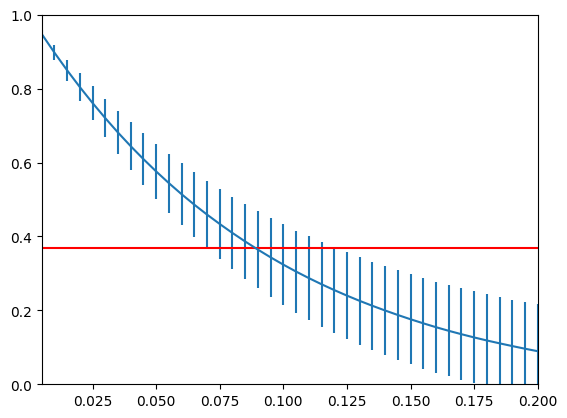

In [12]:
plt.xlim(0.005,0.2)
plt.ylim(0,1.0)
plt.errorbar(window,auto_final[:,0],yerr=auto_final[:,1])
plt.plot(window,np.full(len(window),1.0/np.e),color='r')

As we can notice, the autocorrelation is quite similar to what we expected. The intersection with the $1/e$ line is near the theoretical value of $0.1$ and inside the error band. Moreover, for the upper limit of the window the memory effect is still not completely destroyed. This was not so visible with the production of the SSPDF because it is quite small and the SSPDF still had some irregularities due to the low number of simulations.

## Ornstein-Uhlenbeck Noise in the Harvest Process

It's time now to insert the Ornstein-Uhlenbeck noise in our system. The idea is fairly simple: we substitute the $\xi_(t)$ white noise with $Y(t)$ the noise produced by the zero-mean Ornstein-Uhlenbeck process. Moreover, having $s$ already regulating the amplitude, we will set $\sigma=\sqrt{2/\theta}$ to have unitary variance. Therefore:

$$
dx=\left(a_0x(1-x)-kx+sx(1-x)Y(t)\right)dt+0dW\qquad where \qquad dY=-\frac{1}{\theta}Ydt+\sqrt{\frac{2}{\theta}}dW
$$

As you can notice, the Harvest Process is now characterised by a regulare ODE and not by a SDE.

Nonetheless, we have now another problem because the Harvest Process is no more a 1D process but it is now a 2D system. Thus we need to correct the class to simulate the n-D systems. The idea is the following: working with arrays instead of values!

In [13]:
#The idea is to work with vector. We can use the following notation: in our 2D space the 0-component is for the biomass X
#while the 1-component is OU-noise. REMEMBER: This two components are subjected to different limitations

class HarvestOU(object):
    '''
    This class is used to simulate trajectories for the Harvest Process
    but characterised by a zero mean - unitary variance Ornstein-Uhlenbeck noise.
    '''

    def __init__(self,a: float,k: float,s: float,theta: float)->None:
        self.a = a
        self.k = k
        self.s = s
        self.theta = theta

        if(theta<=0):
            raise RuntimeError("Theta is negative or 0")

        if((a<0)or(k<0)or(s<0)):
            raise RuntimeError("One of the Harvest parameter is negative")

        return

    def __checkInputs(self,x0: np.array,T: float,N: int)->None:
        '''
        Given the inputs for a trajectory, this method will
        check if they are correct
        '''
        if T<0:
            raise RuntimeError("Time interval must have a positive lenght")

        if N<=1:
            raise RuntimeError("The simulation must have at least two steps")

        #For the initial condition we need to check that the X is in [0,1] but not the noise:
        if(x0[0]<0 or x0[0]>1):
            raise RuntimeError("Initial biomass value outside of the domain")

        return

    def __field(self,x: np.array)->np.array:
        '''
        This function, given the 2D coordinate of the HarvestOU, will
        compute the local deterministic field.
        '''

        f = np.zeros(2,dtype=float)

        f[0] = self.a*x[0]*(1-x[0])-self.k*x[0]+self.s*x[0]*(1-x[0])*x[1]
        f[1] = -x[1]/self.theta

        return f

    def __RK4(self,t_n: float,y_n: np.array,h: float)->np.array:
        '''
        Given a point in the trajectory, the time instant and the step lenght,
        this method will compute the variation for y using the RK4 for the 
        deterministic part of the OU process
        '''
        self.__checkInputs(y_n,t_n,10)
        
        if h<=0:
            raise RuntimeError("Given h is negative or 0")

        #This time we do not define on flight the field function but we treat it
        #externally. Doing this we can treat separately the two components
        
        k_1 = self.__field(y_n)
        k_2 = self.__field(y_n+h*k_1/2)
        k_3 = self.__field(y_n+h*k_2/2)
        k_4 = self.__field(y_n+h*k_3)

        return h*(k_1+2*k_2+2*k_3+k_4)/6
        
    def simulateTraj(self,x0: np.array,T: float,N: int):
        '''
        Given the initial population value x0, the considered interval lenght T
        and the number of step in the computation N, this method will return a
        trajectory for the HarvestOU process.
        '''
        self.__checkInputs(x0,T,N)

        if T==0:
            return np.array([x0])

        h = T/N
        traj = np.zeros((N+1,2),dtype=float) #Here the trajectory should become an array of arrays
        traj[0] = x0
        time = np.zeros(N+1,dtype=float)
        time[0] = 0.0

        rng = Generator(PCG64())

        for i in range(1,N+1):
            time[i] = i*h

            #As first step we need to update the deterministic part of the two variables.
            #We can simply update __RK4 to work with vector and outputs update vectors instead of values.
            dx = self.__RK4(time[i-1],traj[i-1],h)

            #For the stochastic part we need only to update the noise component thus
            dx[1] += np.sqrt(2.0/self.theta)*rng.normal()*np.sqrt(h) 
            traj[i] = traj[i-1] + dx

            #And then we need to check only the first component for the domain
            if traj[i][0]<0: traj[i][0]=0.0

        return traj,time

We can now simulate a trajectory. We need to pick $x$ uniformly in $[0,1]$ while for $Y$ we need to pick the value with a normal gaussian

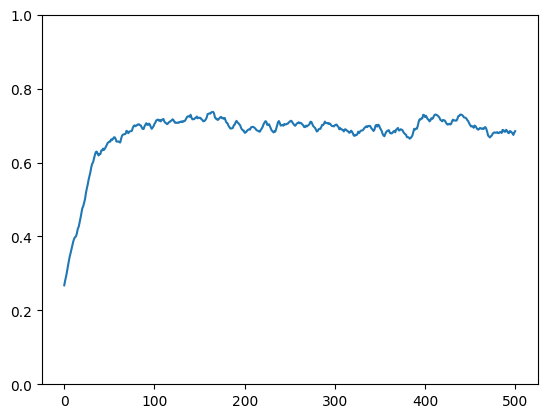

In [14]:
system = HarvestOU(1.0,0.3,0.2,0.1)

rng_0 = Generator(PCG64())

x0 = np.array([rng_0.uniform(0,1),rng_0.standard_normal()])

ptraj,ttraj = system.simulateTraj(x0,50,500)

plt.ylim(0,1)
plt.plot(ptraj[:,0])

The trajectory seems comparable with the already found behaviour where the system is converging to the upper stable point around $1-k/a_0\approx 0.7$. We can try to increase our noise to see if there are some differences. If $s=1.2$ we are surely upon the famous bifurcation value.

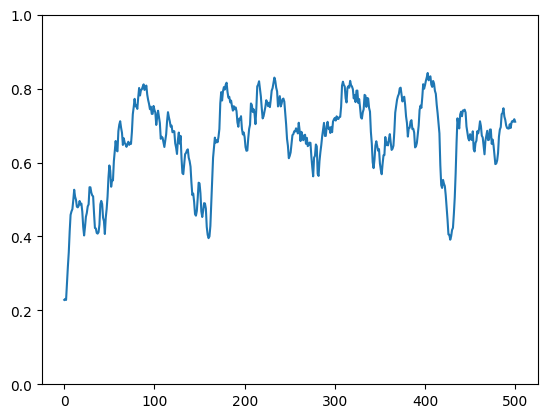

In [15]:
system = HarvestOU(1.0,0.3,1.2,0.1)

rng_0 = Generator(PCG64())

x0 = np.array([rng_0.uniform(0,1),rng_0.standard_normal()])

ptraj,ttraj = system.simulateTraj(x0,50,500)

plt.ylim(0,1)
plt.plot(ptraj[:,0])

It looks like that the behavior is not changed a lot w.r.t the previous case. It seems that the biefurcation did not happen in this situation. Let's try to produce the SSPDF for this case.

In [16]:
#THE PRODUCTION CODE: THIS WILL REQUIRE SOMETIME

omega = [0.0,1.0] 
Nbins = 250 
Nsim = 5000
m = (omega[1]-omega[0])/Nbins
system = HarvestOU(1.0,0.3,1.2,0.1)

rng_0 = Generator(PCG64())

bins = np.zeros(Nbins,dtype=float)

for _ in range(Nsim):
    x0 = np.array([rng_0.uniform(0,1),rng_0.standard_normal()])

    ptraj,ttraj = system.simulateTraj(x0,50,500)
    
    for i in range(Nbins):
        if ptraj[-1][0] < (m*(i+1)+omega[0]):
            bins[i] += 1.0
            break


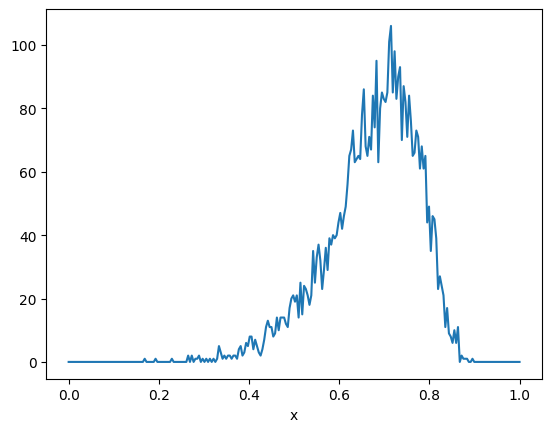

In [17]:
x = np.linspace(omega[0],omega[1],Nbins)
plt.xlabel("x")
plt.plot(x,bins)

It looks very centered in the upper bound. We need to analyse further this problem....